In [3]:
import numpy as np

# Batch design parameters
sites = 512; batch = 20; nsim = sites * batch

# parameters

#storage 
global C; C = np.array([5,10**5]);
global switchCost; switchCost = 10;
global IminMax; IminMax = np.array([0,10]) 
global BminMax; BminMax = np.array([-6,6])

global no_regime; no_regime = 2
global degree; degree = 3

maturity = 24 * 2 # units are in hours

global dt; dt = 15/60;
nstep = int(maturity/dt)

In [4]:
1

192

In [2]:
import numpy as np
# demandSimulate.m
def demandSimulate(α, K0, σ, n_step, n_sim, maturity, P0):
    
    dt = maturity/n_step
    priceMatrix = np.zeros((n_sim, n_step+1))
    priceMatrix[:,0] = np.ones(n_sim) * P0
    
    dW = np.random.normal(0,1,size = (n_sim,n_step) ) * np.sqrt(dt)
    
    for i in range(1,n_step+1):
        priceMatrix[:,i] = priceMatrix[:,i-1] + α * (K0 - priceMatrix[:,i-1]) * dt + σ * dW[:,i-1]
        
    return priceMatrix

In [3]:

from sklearn import preprocessing
import numpy as np


def oneStepOptimization_microgrid(demand,ICord,coeff):
    
    # regime 0= injection, 1 = withdrawal, 2  = do nothing
    # Batch design parameters
    nsim = len(demand)
    
    B_max = BminMax[1];
    B_min = BminMax[0];

    I_max = IminMax[1];
    I_min = IminMax[0];
    
    
    #c_tk in 2D
    possibleControl = np.zeros((nsim,2));
    possibleControl[:,1] = demand*(demand>0) + np.minimum(B_max,(I_max - ICord)/dt)
    
    #notice that demand has one column, but possible control has 2 columns.
    # demandExControl as a result has 2 columns. 

    # ct- Xt for each possible control
    demand2D = np.column_stack((demand,demand))
    demandExControl = possibleControl - demand2D;
    
    ICord2D = np.column_stack((ICord,ICord))
    

    constraint1 = np.maximum(B_min, demandExControl)
    constraint2 = np.minimum(constraint1,B_max)
    constraint3 = np.minimum(constraint2, (I_max - ICord2D)/dt)
    #Bt in 2D
    Bt = np.maximum(-ICord2D/dt, constraint3)

    #St in 2D
    St = demandExControl - Bt
    # I_t+1 effectively
    It = ICord2D + Bt * dt;

    costON = (possibleControl[:,1]**0.9) * dt + C[0] * np.abs(St[:,1])*(St[:,1]>0) * dt + C[1] * np.abs(St[:,1])*(St[:,1]<0) * dt;
    costOFF =  C[0] * np.abs(St[:,0])*(St[:,0]>0) * dt + C[1] * np.abs(St[:,0])*(St[:,0]<0) * dt;
    #V_on
    espBellmanON = np.zeros((nsim,no_regime)); 
    #V_off
    espBellmanOFF=np.zeros((nsim,no_regime));
    #optimal m 
    nextRegime =  np.ones((nsim,no_regime)); 
    # optimal i
    nextInventory = np.zeros((nsim,no_regime));     
    stepCost = np.zeros((nsim,no_regime));    
    cost = np.zeros((nsim,no_regime));     
    imbalance = np.zeros((nsim,no_regime));     
    batteryOutput = np.zeros((nsim,no_regime));
    control = np.zeros((nsim,no_regime));   
    
    # r=0 off and r=1 on, in each one, find optimal contrl next step 
    for r in range(no_regime):
        
        X = np.column_stack((demand, It[:,0]))
        poly = preprocessing.PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)

        pred0 = coeff[0].predict(X_poly)
        espBellmanOFF[:,r] = costOFF +pred0;
        
        X = np.column_stack((demand, It[:,1]))
        poly = preprocessing.PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)

        pred1 = coeff[1].predict(X_poly)
        
        #Vt+1 following mt = r to mt+1 = 1, plus switch cost if r = 0 .
        espBellmanON[:,r] =  costON + pred1 + switchCost*(r==0) ;
        
        #???
        #check = possibleControl[:,1]<0.000001;
        #espBellmanON[check,r]=10**11;
        
        #get indx where Vt+1(off)< Vt+1(on)
        #minimization 
        indx = espBellmanOFF[:,r] < espBellmanON[:,r];
        # optimal mt+1
        nextRegime[:,r] = 0 *indx + 1 *(1-indx);
        #gives pi not pi delta
        stepCost[:,r] =  costOFF * indx + costON * (1-indx);
        # get Vt_1 optimal
        cost[:,r] = espBellmanOFF[:,r] * indx + espBellmanON[:,r] * (1-indx);
        # optimal It+1
        nextInventory[:,r]= It[:,0] * indx + It[:,1] * (1-indx);
        # optimal imbalance following control
        imbalance[:,r]= St[:,0] * indx + St[:,1] * (1-indx);
        #optimal control at t+1starting at r at t
        control[:,r] = possibleControl[:,0] * indx + possibleControl[:,1] * (1-indx);
        batteryOutput[:,r] = Bt[:,0] * indx + Bt[:,1] * (1-indx); 
        
    return [cost, stepCost, control, nextInventory, nextRegime, imbalance, batteryOutput]

In [4]:
import time
start_time = time.time()



from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

from scipy.stats import qmc



    
def microgrid_poly2d():

    # stock
    alpha = 0.5; K0 = 0; sigma = 2; processType = "Regular";

    # backward simulation
    
    sampler = qmc.Sobol(d=2, scramble=False)
    # 512 samples
    W = sampler.random_base2(m=9)
    X0 = -10 + 20*W[:,0]; # X0 in [-10,10]
    ICord = 10*W[:,1];    # Ic in[0,Imax = 10]
    ICord_rep = np.repeat(ICord,batch);
    X0_rep = np.repeat(X0,batch);

    demandMatrix = demandSimulate(alpha, K0, sigma, 1, nsim, dt, X0_rep);
    # I0 is 5
    finalCost = 200 * np.maximum(5-ICord_rep,0)
    # 20 rows, 512 columns,create 20x512 matrix, filled by column wise with order = "F" (default fill row), 
    # take row sum mean  to get final cost for each starting site
    finalCost = np.mean(finalCost.reshape((batch,sites),order = "F"),axis = 0)

    costNext = np.zeros((sites,no_regime));

    for r in range(no_regime):
        costNext[:,r] = finalCost;

    modelIndx = 0; global Model ; Model = [None] * (nstep)
    polyMdl = [None]*no_regime
    for iStep in range(nstep,0,-1):
        for r in range(no_regime):
            polyMdl[r] = LinearRegression()

            X_train = np.column_stack((X0, ICord))

            poly = preprocessing.PolynomialFeatures(degree=3)
            X_poly = poly.fit_transform(X_train)

            y_train = costNext[:, r]
            polyMdl[r].fit(X_poly, y_train)
        
        # generate X_t 
        demandMatrix = demandSimulate(alpha, K0, sigma, 1, nsim, dt, X0_rep);

        # optimize basedd on X_istep+1,I_istep+1
        cost, _, control, nextInventory, nextRegime, imbalance, batteryOutput =oneStepOptimization_microgrid(
            demandMatrix[:, 1], ICord_rep, polyMdl)

        for r in range(no_regime):
            costNext[:, r] = np.mean(cost[:, r].reshape((batch, sites),order = "F"), axis=0)
     
        Model[modelIndx] = polyMdl.copy();
        modelIndx+=1;    


    # forward simulations 
    np.random.seed(10)
    simOutSample = 200000;

    X0 = np.zeros(simOutSample);
    I0 = 5;
    demandMatrix = demandSimulate(alpha, K0, sigma, nstep, simOutSample, maturity, X0);

    inventoryForward = np.zeros((simOutSample,nstep+1));
    inventoryForward[:, 0] = I0

    regimeForward = np.zeros((simOutSample, nstep + 1))
    regimeForward[:, 0] = 0
    
    Bt = np.zeros((simOutSample, nstep))
    St = np.zeros((simOutSample, nstep))
    dieselPower = np.zeros((simOutSample, nstep))
    trueCost = np.zeros((simOutSample, nstep))
    artificialCost = np.zeros((simOutSample, nstep))
    
    costForward = np.zeros((simOutSample, nstep + 1))
    
    for iStep in range(nstep):
        _, _, control, nextInventory, nextRegime, imbalance, batteryOutput = \
        oneStepOptimization_microgrid(demandMatrix[:, iStep], inventoryForward[:, iStep], Model[nstep - iStep-1])
        row_idx = tuple(np.arange(0,simOutSample))
        col_idx = tuple(np.int64(regimeForward[:,iStep]))
        print(col_idx[:10],iStep,nstep)
        inventoryForward[:, iStep + 1] = nextInventory[row_idx,col_idx]
        regimeForward[:, iStep + 1] = nextRegime[row_idx,col_idx]
        Bt[:, iStep] = batteryOutput[row_idx,col_idx]
        St[:, iStep] = imbalance[row_idx,col_idx]
        dieselPower[:, iStep] = control[row_idx,col_idx]
        
        trueCost[:, iStep] = (dieselPower[:, iStep] ** 0.9) * dt + switchCost * (regimeForward[:, iStep + 1] \
                                                                                 > regimeForward[:, iStep])
        artificialCost[:, iStep] = C[0] * np.abs(St[:, iStep]) * (St[:, iStep] > 0) * dt + \
        C[1] * np.abs(St[:, iStep]) * (St[:, iStep] < 0) * dt
    
    penalty = 200 * np.maximum(I0-inventoryForward[:, -1] ,0)
    costForward = trueCost + artificialCost
    pathWiseCost = np.sum(costForward, axis=1) + penalty
    totalCost = np.mean(pathWiseCost)
    stdDeviation = np.std(pathWiseCost) / np.sqrt(simOutSample)
    totalTrueCost = np.mean(np.sum(trueCost, axis=1))
    totalArtificialCost = np.mean(np.sum(artificialCost, axis=1))
    
    print(f'nsim: {sites} x {batch}, regime=1, totalCost= {totalCost}, totalTrueCost= {totalTrueCost}, totalArtificialCost= {totalArtificialCost}')


    return [demandMatrix,inventoryForward,Bt,St,dieselPower,regimeForward]

In [5]:
mdl = microgrid_poly2d()

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 1 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 2 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 3 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 4 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 5 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 6 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 7 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 8 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 9 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 10 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 11 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 12 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 13 192
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0) 14 192
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0) 15 192
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0) 16 192
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0) 17 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 18 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 19 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 20 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 21 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 22 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 23 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 24 192
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 25 192
(0, 0, 0, 0, 0, 0, 0, 

In [6]:
res_demand = mdl[0][0,:] #193
opt_It = mdl[1][0,:] 
opt_Bt  = mdl[2][0,:]
opt_imbalance = mdl[3][0,:]
opt_diesel = mdl[4][0,:]
opt_regimes = mdl[5][0,:]

[]

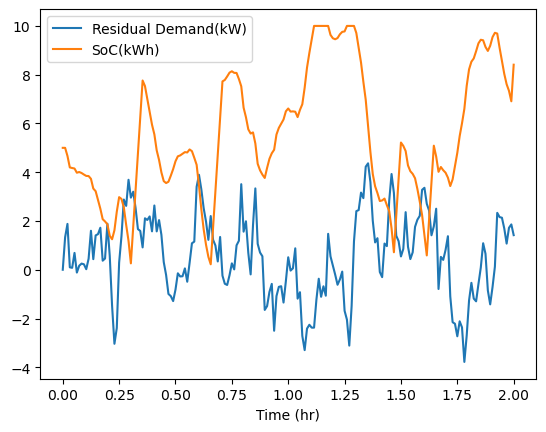

In [7]:
import matplotlib.pyplot as plt
t = np.linspace(0,2,193)

plt.plot(t,res_demand)
plt.plot(t,opt_It)
#plt.plot(t,np.insert(opt_diesel,0,0))
plt.legend(["Residual Demand(kW)", "SoC(kWh)", "Diesel Power"])
# demand is negative, charge, demand is positive, discharge

plt.xlabel("Time (hr)")

plt.plot()

# Here residual demand only goes up and down around 4. But in training, we train [-10,10]

[]

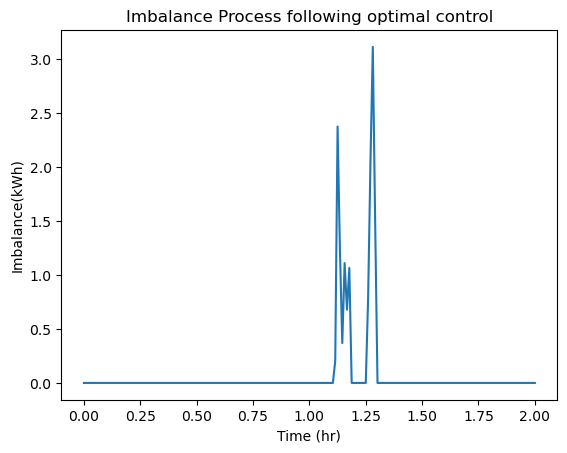

In [8]:
import matplotlib.pyplot as plt
t = np.linspace(0,2,193)


plt.plot(t,np.insert(opt_imbalance,0,0))

# demand is negative, charge, demand is positive, discharge
plt.ylabel("Imbalance(kWh)")
plt.xlabel("Time (hr)")
plt.title("Imbalance Process following optimal control")
plt.plot()